In [1]:
#imports libraries that will be utilized
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import requests
import scipy.stats as sts
import scipy as spy
import scipy.integrate as integrate
import scipy.optimize as opt

QUESTION 1

Literal a)

/Users/Daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '%')

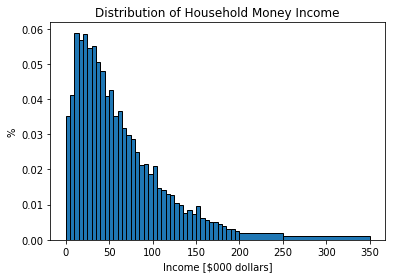

In [2]:
#loads information and produces histogram adjusting for the width of the two last bins
dt1=pd.read_csv('usincmoms.txt',delimiter='\t', header=None)
dt1.columns=["PercInc","MidP"]
MidPHist=dt1['MidP']/1000
bins1=list(MidPHist-2.5)
bins1[len(bins1)-2]=200
bins1[len(bins1)-1]=250
bins1=bins1+[350]
height1=dt1['PercInc']
height1[len(height1)-2]=height1[len(height1)-2]/10
height1[len(height1)-1]=height1[len(height1)-1]/20

plt.hist(MidPHist, bins = bins1, weights = height1, edgecolor = 'black')
plt.title('Distribution of Household Money Income')
plt.xlabel('Income [$000 dollars]')
plt.ylabel('%')

Literal b)

Estimated mu= 3.9041080873710468
Estimated sigma= 1.143520468237584
Value of Minimized Criterion Function = 0.05736857653950836


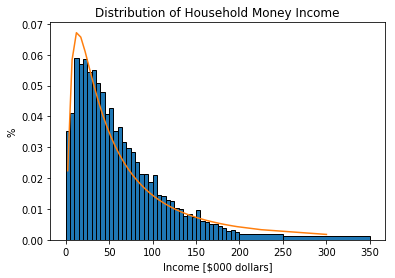

In [3]:
#Using the GMM method, fits a lognormal distribution to the data

#takes the data moments, calculates the weighting matrix and defines starting mu and sigma values
mb=dt1['PercInc']
Wb=np.eye(42)
for x in range (0,len(dt1['PercInc'])):
    Wb[x][x]=Wb[x][x]*dt1['PercInc'][x]

mu0b=np.log(np.sum(dt1['PercInc']*MidPHist))
sigma0b=np.std(dt1['PercInc']*MidPHist)

#defines minimization criteria: takes the lognormal integral within the bins defined 
#computes the error as defined in the GMM method
def erb(params):
    mu, sigma = params
    mx=dt1['PercInc']

    mxe=[]
    for c in range (0,len(dt1['PercInc'])):
        mxe.append(sts.lognorm.cdf(bins1[c+1],s=sigma, scale=np.exp(mu))-sts.lognorm.cdf(bins1[c],s=sigma, scale=np.exp(mu)))

    
    mxe[41]=1-sts.lognorm.cdf(bins1[len(dt1['PercInc'])-1],s=sigma, scale=np.exp(mu))
    
    errb = (mx - mxe)/mxe

    estimatorb=errb.T @ Wb @ errb
    
    return estimatorb
                   
#takes initial estimates for values and minimizes criteria function
#prints results
params_0=np.array([mu0b, sigma0b])
results_uncstrb = opt.minimize(erb, params_0, method='BFGS')
mub, sigmab = results_uncstrb.x
print('Estimated mu=', mub) 
print('Estimated sigma=', sigmab)
params_b=np.array([mub, sigmab])
print('Value of Minimized Criterion Function =', erb(params_b))

#plots results adjusting for the width of the last two bins
plt.hist(MidPHist, bins = bins1, weights = height1, edgecolor = 'black', label='Initial distribution')
plt.title('Distribution of Household Money Income')
plt.xlabel('Income [$000 dollars]')
plt.ylabel('%')

ptmxeb=[]
for c in range (0,len(dt1['PercInc'])):
    ptmxeb.append(sts.lognorm.cdf(bins1[c+1],s=sigmab, scale=np.exp(mub))-sts.lognorm.cdf(bins1[c],s=sigmab, scale=np.exp(mub)))
    
ptmxeb[40] = ptmxeb[40] / 10
ptmxeb[41] = ptmxeb[41] / 20
plt.plot(MidPHist, ptmxeb, label='Lognormal estimation')


Literal c:

Estimated Alpha= 1.4025664250145906
Estimated Beta= 45.50801488509592
Value of Minimized Criterion Function = 0.007800980066791557


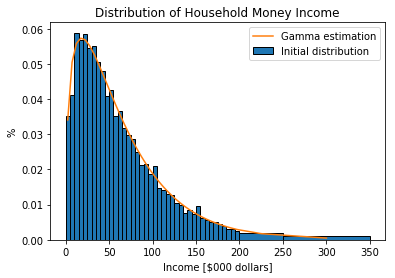

In [4]:
#Using the GMM method, fits a gamma distribution to the data

#takes the data moments, calculates the weighting matrix and defines starting mu and sigma values
mc=dt1['PercInc']
Wc=np.eye(42)
for x in range (0,len(dt1['PercInc'])):
    Wc[x][x]=Wc[x][x]*dt1['PercInc'][x]

a0c=3
b0c=20000

#defines minimization criteria: takes the gamma integral within the bins defined 
#computes the error as defined in the GMM method
def erc(params):
    alpha, beta = params
    mx=dt1['PercInc']

    mxec=[]
    for c in range (0,len(dt1['PercInc'])):
        mxec.append(sts.gamma.cdf(bins1[c+1],a=alpha, scale=beta)-sts.gamma.cdf(bins1[c],a=alpha, scale=beta))

    
    mxec[41]=1-sts.gamma.cdf(bins1[len(dt1['PercInc'])-1],a=alpha, scale=beta)
    
    errc = (mx - mxec)/mxec

    estimatorc=errc.T @ Wc @ errc
    
    return estimatorc
                   
#takes initial estimates for values and minimizes criteria function
#prints results
params_0=np.array([a0c, b0c])
results_uncstrc = opt.minimize(erc, params_0, method='Nelder-Mead')
alphac, betac = results_uncstrc.x
print('Estimated Alpha=', alphac) 
print('Estimated Beta=', betac)
params_c=np.array([alphac, betac])
print('Value of Minimized Criterion Function =', erc(params_c))
    
#plots results adjusting for the width of the last two bins    
plt.hist(MidPHist, bins = bins1, weights = height1, edgecolor = 'black',label='Initial distribution')
plt.title('Distribution of Household Money Income')
plt.xlabel('Income [$000 dollars]')
plt.ylabel('%')

ptmxec=[]
for c in range (0,len(dt1['PercInc'])):
    ptmxec.append(sts.gamma.cdf(bins1[c+1],a=alphac, scale=betac)-sts.gamma.cdf(bins1[c],a=alphac, scale=betac))  

ptmxec[41] = 1-sts.gamma.cdf(bins1[len(dt1['PercInc'])-1],a=alphac, scale=betac)
ptmxec[40] = ptmxec[40] / 10
ptmxec[41] = ptmxec[41] / 20
plt.plot(MidPHist, ptmxec, label = 'Gamma estimation')
plt.legend()


Literal d:

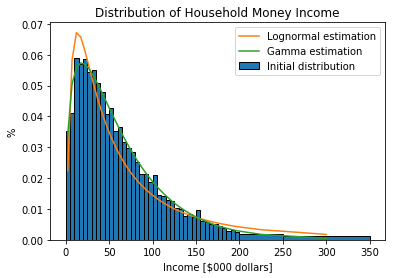

In [5]:
#plots results from literals b) and c) onto the initial histogram
plt.hist(MidPHist, bins = bins1, weights = height1, edgecolor = 'black', label='Initial distribution')
plt.title('Distribution of Household Money Income')
plt.xlabel('Income [$000 dollars]')
plt.ylabel('%')

plt.plot(MidPHist, ptmxeb, label='Lognormal estimation')
plt.plot(MidPHist, ptmxec, label='Gamma estimation')
plt.legend()


The best way would be to look at the values of the minimized criterion functions, which are: 

In [6]:
print('Lognormal Minimized criterion=',erb(params_b))
print('Gamma Minimized criterion=',erc(params_c))

Lognormal Minimized criterion= 0.05736857653950836
Gamma Minimized criterion= 0.007800980066791557


Since the value for the estimated gamma distribution is smaller/lower, we can say it fits the data better.

QUESTION 2

Literal a:

In [7]:
#Loads information and defines initial values for parameters, as well as the weighting matrix
dt2=pd.read_csv('MacroSeries.txt',sep=",",header=None)
dt2.columns=["c","k","w","r"]
beta2=0.99
alpha_02=1/2
rho_02=1/2
mu_02=1
W2=np.eye(4)

#function that calculates the z straight from the data (and alpha) based on equation 4.
def function4z(al,rt,kt):
    zt=np.log(rt)-np.log(al)-(al-1)*np.log(kt)
    return zt

#defines minimization criteria
#calculates moments as defined in problem set
#computes the error as defined in the GMM method
def crit2(params):
    alpha,rho,mu = params
    impz=function4z(alpha,dt2['r'],dt2['k'])

    m1=[]
    m2=[]
    m3=[]
    m4=[]
    
    for i in range (0, len(dt2['c'])-1):
    
        zt=function4z(alpha,dt2['r'][i],dt2['k'][i])
        zt1=function4z(alpha,dt2['r'][i+1],dt2['k'][i+1])
        m1.append(zt1-(rho*zt)-((1-rho)*mu))
        m2.append((zt1-(rho*zt)-((1-rho)*mu))*zt)
        m3.append((beta2*alpha*np.exp(zt1)*((dt2['k'][i+1])**(alpha-1))*((dt2['c'][i])/(dt2['c'][i+1])))-1)
        m4.append(((beta2*alpha*np.exp(zt1)*((dt2['k'][i+1])**(alpha-1))*((dt2['c'][i])/(dt2['c'][i+1])))-1)*dt2['w'][i])
        
    
    err2=np.array([np.mean(m1),np.mean(m2),np.mean(m3),np.mean(m4)])
    
    estimator2=err2.T @ W2 @ err2
    
    return estimator2

#takes initial estimates for values and minimizes criteria function
#prints results
params_02=np.array([alpha_02,rho_02,mu_02])
results_uncstr2 = opt.minimize(crit2, params_02, method='L-BFGS-B',bounds=((1e-10,0.999), (-0.99, 0.99),(1e-10, None)),tol=1e-15)
alpha2, rho2, mu2 = results_uncstr2.x
print('Estimated Alpha=', alpha2) 
print('Estimated Rho=', rho2)
print('Estimated Mu=', mu2)
params_2=np.array([alpha2, rho2, mu2])
print('Value of Minimized Criterion Function =', crit2(params_2))

Estimated Alpha= 0.49094421189871523
Estimated Rho= 0.4899531866123117
Estimated Mu= 8.770904198296101
Value of Minimized Criterion Function = 1.4111709241847263e-07
